# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**

### Required Packages
##### Uncomment the packages you need to install or are missing

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install mplfinance
#!pip install pandas-datareader
#!pip install requests_cache
#!pip install alphaVantage-api

In [2]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

import numpy as np # pip install numpy
import pandas as pd # pip install pandas
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 20)

import mplfinance as mpf # pip mplfinance
import pandas_datareader as pdr # pip install pandas-datareader
import requests_cache # pip install requests_cache

from alphaVantageAPI.alphavantage import AlphaVantage  # pip install alphaVantage-api
import pandas_ta as ta

# from pandas_datareader.famafrench import get_available_datasets
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# from watchlist import famafrench, Fred, Watchlist
from watchlist import Watchlist
# from watchlist import Fred, Watchlist

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"Pandas TA v{ta.version}")
print(f"Pandas Data Reader v{pdr.__version__}")
print(f"yfinance v{yf.__version__}")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib
Numpy v1.18.3
Pandas v1.1.0
mplfinance v0.12.6a3
Pandas TA v0.1.95b
Pandas Data Reader v0.9.0
yfinance v0.1.54


## MISC Functions

In [3]:
def cscheme(colors: str):
    aliases = {
        "BkBu": ["black", "blue"],
        "gr": ["green", "red"],
        "grays": ["silver", "gray"],
        "mas": ["black", "green", "orange", "red"],
        "bbands": ["blue", "navy", "blue"],
        "kc": ["purple", "fuchsia", "purple"],
    }
    aliases["default"] = aliases["gr"]
    return aliases[colors]

def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 3
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 3}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.TRADING_DAYS_PER_YEAR / yd) if yd > 0 else df.shape[0]

## Collect some Data

In [4]:
tickers = ["SPY", "QQQ"]
watch = Watchlist(tickers)
watch.load(tickers, timed=True, verbose=True)

[!] Loading All: SPY, QQQ
[i] Loaded['D']: SPY_D.csv
[+] Strategy: Common Price and Volume SMAs
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Total indicators: 5
[i] Columns added: 5
[i] Runtime: 46.8974 ms (0.0469 s)
[+] Downloading['D']: QQQ
[+] Strategy: Common Price and Volume SMAs
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Total indicators: 5
[i] Columns added: 5
[i] Runtime: 17.1018 ms (0.0171 s)


In [5]:
ticker = tickers[1]
watch.data[ticker].ta.constants(True, [0, 0, 0])
watch.data[ticker].columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_10', 'SMA_20', 'SMA_50',
       'SMA_200', 'VOL_SMA_20', '0'],
      dtype='object')

In [6]:
recent = recent_bars(watch.data[ticker], "2y")
asset = watch.data[ticker].copy().tail(recent)

# Build some Trends

In [7]:
# Example Long Trends
long = asset.SMA_10 > asset.SMA_20
# long = asset.SMA_50 > asset.SMA_200
# long = (ta.rsi(asset.close) > 20) & (ta.rsi(asset.close) < 80)
# long = ta.macd(asset.close).iloc[:,1] > 0

# Calculate Trend Returns from the long trend
trendy = asset.ta.trend_return(trend=long, cumulative=True, append=True)
trendy.tail() # Third Column is the long trend binary sequence

,CLTR,TR_LOGRET,CLTR_Trends,CLTR_Trades
date,,,,
2020-08-17,0.392134,0.011544,1,0.0
2020-08-18,0.401713,0.009579,1,0.0
2020-08-19,0.394963,-0.006750,1,0.0
2020-08-20,0.408739,0.013776,1,0.0
2020-08-21,0.415646,0.006906,1,0.0


## Trend Returns and Cumulative Trend Returns

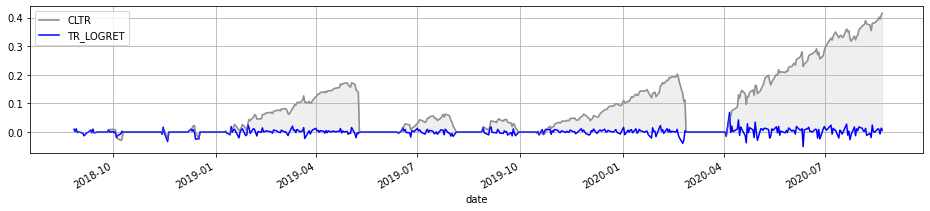

In [8]:
cltr = trendy.iloc[:,0]
tr = trendy.iloc[:,1]

trendy.iloc[:,:2].plot(figsize=(16, 3), color=["gray", "blue"])#, grid=True)
cltr.plot(figsize=(16, 3), kind="area", stacked=False, color=["silver"], alpha=0.25, grid=True)

# Total Return

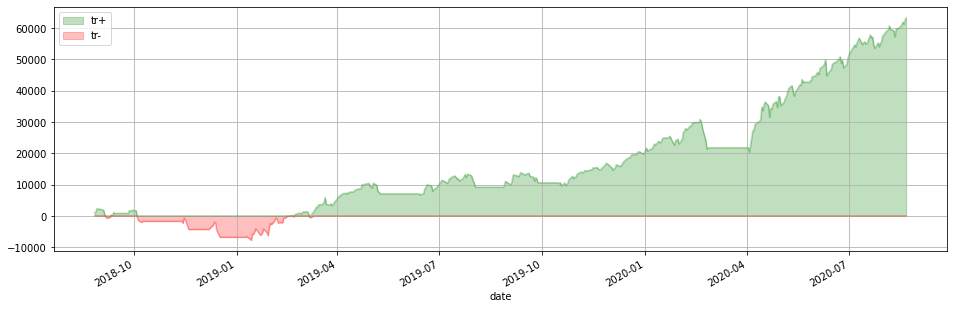

In [9]:
capital = 100000

total_return = tr.cumsum() * capital
positive_return = total_return[total_return > 0]
negative_return = total_return[total_return <= 0]
trdf = pd.DataFrame({"tr+": positive_return, "tr-": negative_return})
trdf.plot(figsize=(16, 5), color=["green", "red"], kind="area", stacked=False, alpha=0.25, grid=True)

In [10]:
# avg_total_return = ta.sma(total_return, 5)
# avg_total_return.plot(figsize=(16, 5), color=["black"], grid=True)

## Long and Short Trends

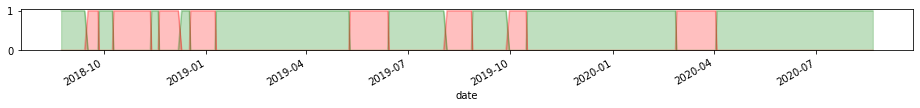

In [11]:
long_trend = (trendy.iloc[:,-2] > 0).astype(int)
short_trend = (1 - long_trend).astype(int)

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=["green"], alpha=0.25)
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=["red"], alpha=0.25)

## Entries & Exits

Total Trades: 16.0


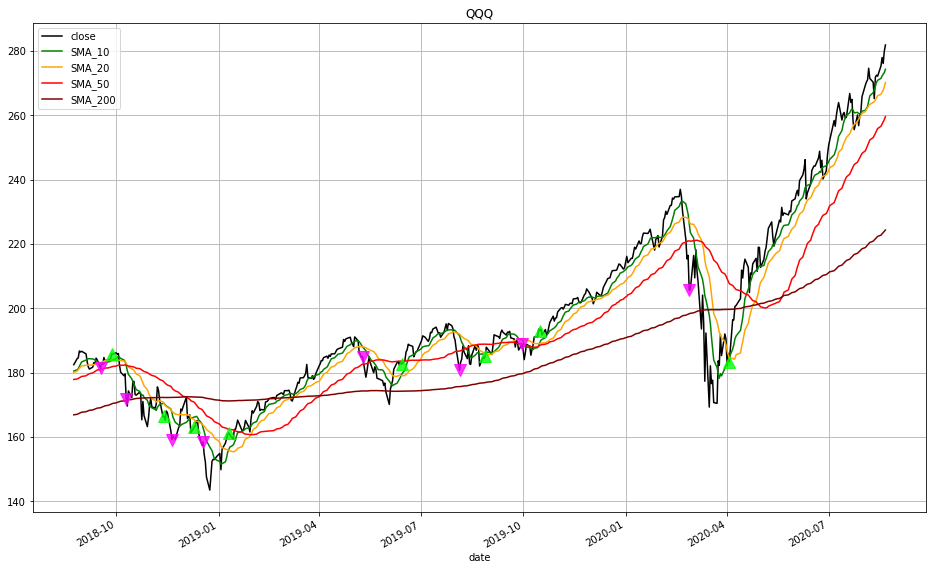

In [12]:
entries = (trendy.iloc[:,-1] > 0).astype(int) * asset.close
entries[entries < 0.0001] = np.NaN
entries.name = "entries"
exits = (trendy.iloc[:,-1] < 0).astype(int) * asset.close
exits[exits < 0.0001] = np.NaN
exits.name = "exits"

asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]].plot(figsize=(16, 10), color=["black", "green", "orange", "red", "maroon"], title=f"{ticker}", grid=True)
entries.plot(figsize=(16, 10), color=["lime"], marker="^", markersize=12, alpha=0.8)
exits.plot(figsize=(16, 10), color=["fuchsia"], marker="v", markersize=12, alpha=0.8, grid=True)

total_trades = trendy.iloc[:,-1].abs().sum()
print(f"Total Trades: {total_trades}")

entries_ = entries.dropna()
exits_ = exits.dropna()
all_trades = trendy.iloc[:,-1].copy().dropna()

# print(f"Long Entries: {[x for x in list(entries_.index)]}")
# print(f"Short Entries: {[x for x in list(exits_.index)]}")
# print(f"ALL Entries: {[x for x in list(all_trades[all_trades != 0].index)]}")

# AI Analysis